In [33]:
from eval import analyze_model

import pandas as pd
import torch
import numpy as np
from pmf import PMF
from lr import LogReg
import pickle

SEED = 42
K_FOLDS = 5
REPLACEMENT_LEVELS = [25, 50, 100, 250, 500, 1000]
LATENT_FACTORS = [1, 2, 3, 4, 5]

In [34]:
df = pd.read_csv('data/men_data.csv')

from sklearn.model_selection import KFold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    for replacement_level in REPLACEMENT_LEVELS:
        with open(f"models/lr/model_rl_{replacement_level}_fold_{fold}.pkl", 'rb') as f:
            lr_model = pickle.load(f)
        for num_factors in LATENT_FACTORS:
            results.append({
                'model_type': 'lr',
                'replacement_level': replacement_level,
                'num_factors': num_factors,
                'fold': fold,
                'train_results': analyze_model(lr_model, train),
                'test_results': analyze_model(lr_model, test)
            })

        for num_factors in LATENT_FACTORS:
            pmf_model = torch.load(f"models/pmf/model_rl_{replacement_level}_d_{num_factors}_fold_{fold}.pth")
            pmf_model.eval()
            results.append({
                'model_type': 'pmf',
                'replacement_level': replacement_level,
                'num_factors': num_factors,
                'fold': fold,
                'train_results': analyze_model(pmf_model, train),
                'test_results': analyze_model(pmf_model, test)
            })

results = pd.DataFrame(results)
results

Shape of X for prediction: (76187, 545)
Number of features expected by the model: 545
Shape of X for prediction: (19047, 545)
Number of features expected by the model: 545
Shape of X for prediction: (76187, 545)
Number of features expected by the model: 545
Shape of X for prediction: (19047, 545)
Number of features expected by the model: 545
Shape of X for prediction: (76187, 545)
Number of features expected by the model: 545
Shape of X for prediction: (19047, 545)
Number of features expected by the model: 545
Shape of X for prediction: (76187, 545)
Number of features expected by the model: 545
Shape of X for prediction: (19047, 545)
Number of features expected by the model: 545
Shape of X for prediction: (76187, 545)
Number of features expected by the model: 545
Shape of X for prediction: (19047, 545)
Number of features expected by the model: 545
Shape of X for prediction: (76187, 334)
Number of features expected by the model: 334
Shape of X for prediction: (19047, 334)
Number of feat

,model_type,replacement_level,num_factors,fold,train_results,test_results
0,lr,25,1,0,"{'Accuracy': 0.7283919828842191, 'Log Loss': 0...","{'Accuracy': 0.723841024833307, 'Log Loss': 0...."
1,lr,25,2,0,"{'Accuracy': 0.7283919828842191, 'Log Loss': 0...","{'Accuracy': 0.723841024833307, 'Log Loss': 0...."
2,lr,25,3,0,"{'Accuracy': 0.7283919828842191, 'Log Loss': 0...","{'Accuracy': 0.723841024833307, 'Log Loss': 0...."
3,lr,25,4,0,"{'Accuracy': 0.7283919828842191, 'Log Loss': 0...","{'Accuracy': 0.723841024833307, 'Log Loss': 0...."
4,lr,25,5,0,"{'Accuracy': 0.7283919828842191, 'Log Loss': 0...","{'Accuracy': 0.723841024833307, 'Log Loss': 0...."
...,...,...,...,...,...,...
295,pmf,1000,1,4,"{'Accuracy': 0.7361264241087835, 'Log Loss': 0...","{'Accuracy': 0.7271343064160454, 'Log Loss': 0..."
296,pmf,1000,2,4,"{'Accuracy': 0.7423741271591326, 'Log Loss': 0...","{'Accuracy': 0.7216738422765935, 'Log Loss': 0..."
297,pmf,1000,3,4,"{'Accuracy': 0.7458261143487164, 'Log Loss': 0...","{'Accuracy': 0.7273443242675628, 'Log Loss': 0..."
298,pmf,1000,4,4,"{'Accuracy': 0.7460361211739381, 'Log Loss': 0...","{'Accuracy': 0.7268192796387692, 'Log Loss': 0..."


In [35]:
metrics = pd.concat([
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors', 'fold']],
            results['train_results'].apply(pd.Series).assign(dataset = "train")
        ], axis = 1
    ),
    pd.concat(
        [
            results[['model_type', 'replacement_level', 'num_factors', 'fold']],
            results['test_results'].apply(pd.Series).assign(dataset = "test")
        ], axis = 1
    )
])

metrics.head()

,model_type,replacement_level,num_factors,fold,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score,dataset
0,lr,25,1,0,0.728392,0.541632,0.181688,0.760893,0.79662,train
1,lr,25,2,0,0.728392,0.541632,0.181688,0.760893,0.79662,train
2,lr,25,3,0,0.728392,0.541632,0.181688,0.760893,0.79662,train
3,lr,25,4,0,0.728392,0.541632,0.181688,0.760893,0.79662,train
4,lr,25,5,0,0.728392,0.541632,0.181688,0.760893,0.79662,train


In [36]:
metrics_long = pd.melt(
    metrics,
    id_vars = ['model_type', 'replacement_level', 'num_factors', 'fold', 'dataset'],
    value_vars = ['Accuracy', 'Log Loss', 'Brier Score', 'F1 Score', 'ROC Score'],
    var_name = 'metric'
)

metrics_long

,model_type,replacement_level,num_factors,fold,dataset,metric,value
0,lr,25,1,0,train,Accuracy,0.728392
1,lr,25,2,0,train,Accuracy,0.728392
2,lr,25,3,0,train,Accuracy,0.728392
3,lr,25,4,0,train,Accuracy,0.728392
4,lr,25,5,0,train,Accuracy,0.728392
...,...,...,...,...,...,...,...
2995,pmf,1000,1,4,test,ROC Score,0.800750
2996,pmf,1000,2,4,test,ROC Score,0.785287
2997,pmf,1000,3,4,test,ROC Score,0.795364
2998,pmf,1000,4,4,test,ROC Score,0.791758


In [37]:
plot_data = (
    metrics_long
    .groupby(['model_type', 'replacement_level', 'num_factors', 'dataset', 'metric'])
    ['value'].agg(['mean', 'std', 'size'])
    .reset_index()
    .assign(
        se = lambda d: d['std'] / d['size'].apply(np.sqrt),
        mean_err_min = lambda d: d['mean'] - 1.96 * d.se,
        mean_err_max = lambda d: d['mean'] + 1.96 * d.se,
        rl = lambda d: pd.Categorical(d['replacement_level']).rename_categories(lambda x: f"$N = {x}$")
    )
)

plot_data

,model_type,replacement_level,num_factors,dataset,metric,mean,std,size,se,mean_err_min,mean_err_max,rl
0,lr,25,1,test,Accuracy,0.723229,0.003237,5,0.001448,0.720392,0.726066,$N = 25$
1,lr,25,1,test,Brier Score,0.184051,0.001775,5,0.000794,0.182495,0.185607,$N = 25$
2,lr,25,1,test,F1 Score,0.755588,0.004705,5,0.002104,0.751463,0.759712,$N = 25$
3,lr,25,1,test,Log Loss,0.547147,0.004334,5,0.001938,0.543348,0.550946,$N = 25$
4,lr,25,1,test,ROC Score,0.791143,0.003603,5,0.001611,0.787985,0.794302,$N = 25$
...,...,...,...,...,...,...,...,...,...,...,...,...
595,pmf,1000,5,train,Accuracy,0.747527,0.001683,5,0.000753,0.746052,0.749002,$N = 1000$
596,pmf,1000,5,train,Brier Score,0.167344,0.000956,5,0.000428,0.166506,0.168182,$N = 1000$
597,pmf,1000,5,train,F1 Score,0.778051,0.001970,5,0.000881,0.776324,0.779778,$N = 1000$
598,pmf,1000,5,train,Log Loss,0.496888,0.002752,5,0.001231,0.494477,0.499300,$N = 1000$


In [38]:
plot_data['metric'] = pd.Categorical(plot_data['metric'], ordered = True, categories = ['Accuracy', 'F1 Score', 'ROC Score', 'Log Loss', 'Brier Score'])

In [39]:
plot_data

,model_type,replacement_level,num_factors,dataset,metric,mean,std,size,se,mean_err_min,mean_err_max,rl
0,lr,25,1,test,Accuracy,0.723229,0.003237,5,0.001448,0.720392,0.726066,$N = 25$
1,lr,25,1,test,Brier Score,0.184051,0.001775,5,0.000794,0.182495,0.185607,$N = 25$
2,lr,25,1,test,F1 Score,0.755588,0.004705,5,0.002104,0.751463,0.759712,$N = 25$
3,lr,25,1,test,Log Loss,0.547147,0.004334,5,0.001938,0.543348,0.550946,$N = 25$
4,lr,25,1,test,ROC Score,0.791143,0.003603,5,0.001611,0.787985,0.794302,$N = 25$
...,...,...,...,...,...,...,...,...,...,...,...,...
595,pmf,1000,5,train,Accuracy,0.747527,0.001683,5,0.000753,0.746052,0.749002,$N = 1000$
596,pmf,1000,5,train,Brier Score,0.167344,0.000956,5,0.000428,0.166506,0.168182,$N = 1000$
597,pmf,1000,5,train,F1 Score,0.778051,0.001970,5,0.000881,0.776324,0.779778,$N = 1000$
598,pmf,1000,5,train,Log Loss,0.496888,0.002752,5,0.001231,0.494477,0.499300,$N = 1000$


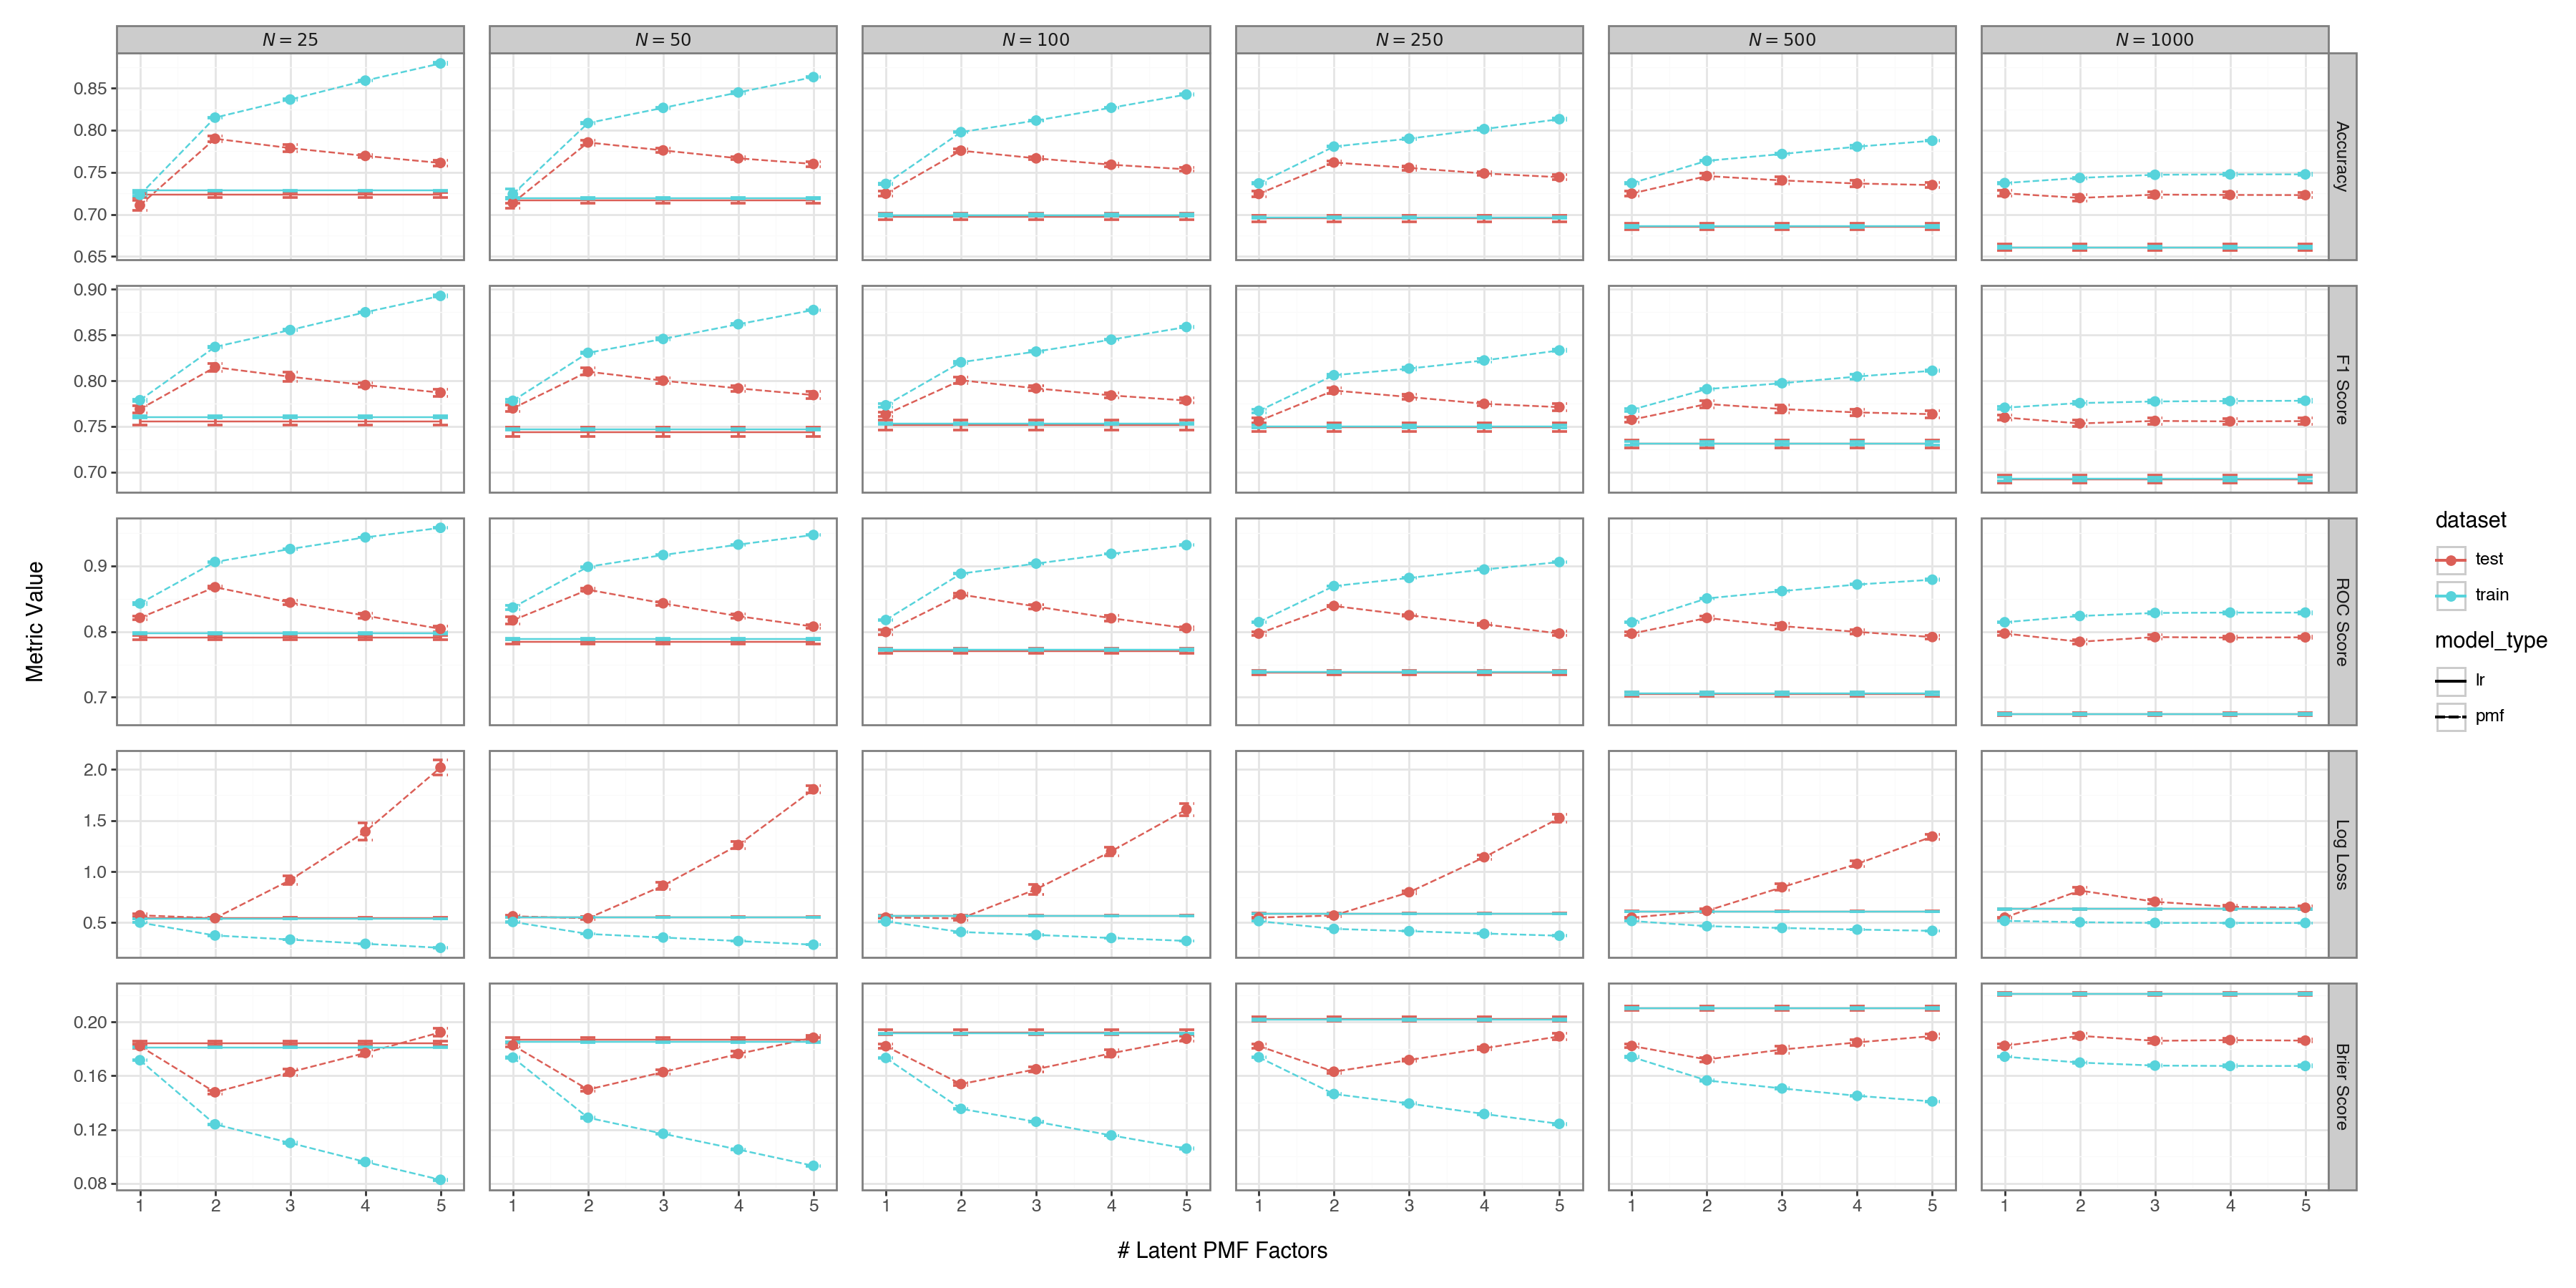

In [40]:
import plotnine
from plotnine import *

plotnine.options.figure_size = (18,9)
p = (
  plot_data
  .pipe(ggplot, aes(x = "num_factors", y = "mean", color = "dataset", linetype = "model_type")) +
  # Add horizontal lines for logistic regression
  # geom_hline(aes(yintercept = "mean", color = "dataset"), data = plot_data.query("model_type == 'lr'")) +
  # Add lines and points for PMF
  geom_line() +
  geom_errorbar(aes(ymin = "mean_err_min", ymax = "mean_err_max"), width = 0.2, size = 0.75) +
  geom_point(size = 2, data = plot_data.query("model_type == 'pmf'")) +
  facet_grid("metric ~ rl", scales = "free_y") +
  labs(x = "# Latent PMF Factors", y = "Metric Value") +
  theme_bw()
)


p

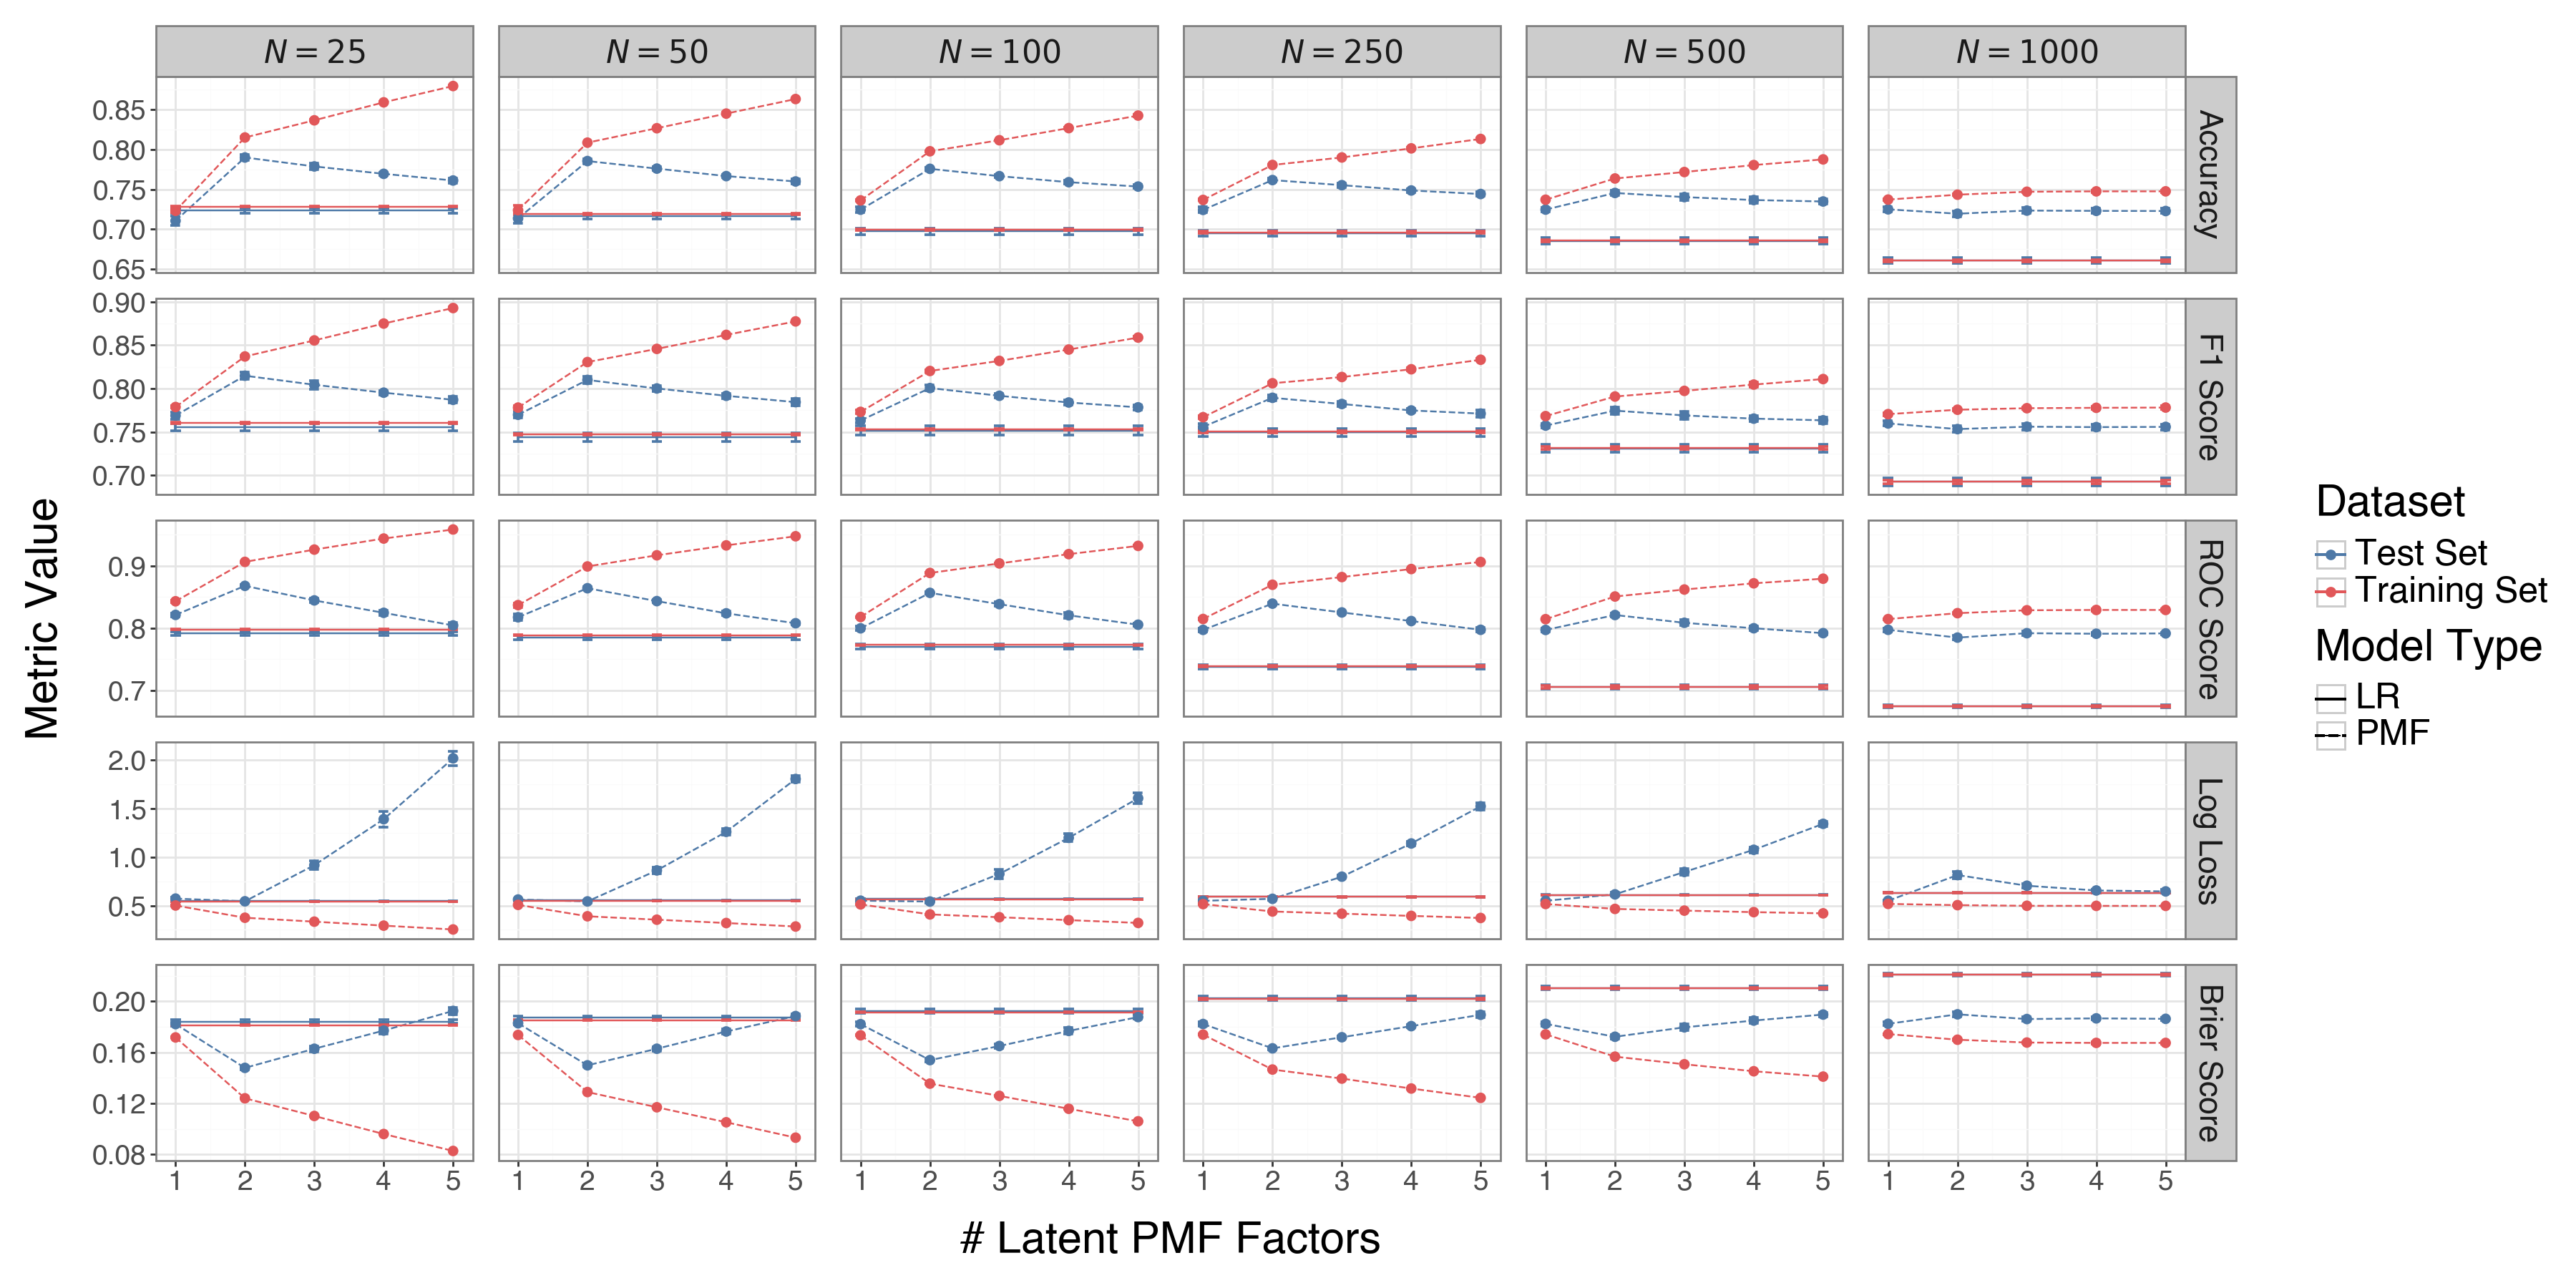

In [41]:
import plotnine 
from plotnine import * 

plotnine.options.figure_size = (18,9)
p = (
  plot_data
  .pipe(ggplot, aes(x = "num_factors", y = "mean", color = "dataset", linetype = "model_type")) +
  # Add horizontal lines for logistic regression
  # geom_hline(aes(yintercept = "mean", color = "dataset"), data = plot_data.query("model_type == 'lr'")) +
  # Add lines and points for PMF
  geom_line() +
  geom_errorbar(aes(ymin = "mean_err_min", ymax = "mean_err_max"), width = 0.15, size = 0.75) +
  geom_point(size = 2, data = plot_data.query("model_type == 'pmf'")) +
  facet_grid("metric ~ rl", scales = "free_y") +
  labs(x = "# Latent PMF Factors", y = "Metric Value", color = "Dataset", linetype = "Model Type", size = '48pt') +
  scale_color_manual(
      values=["#4E79A7", "#E15759"],  # Viridis colors
      labels=["Test Set", "Training Set"]
      ) +
    scale_linetype_manual(
        values={"lr": "solid", "pmf": "dashed"},
        labels={"lr": "LR", "pmf": "PMF"}
    ) +
    theme_bw() +
    theme(
        axis_title=element_text(size=22),
        axis_text=element_text(size=14),
        legend_title=element_text(size=22),
        legend_text=element_text(size=18),
        strip_text=element_text(size=16)
    )
)

p